In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline


In [2]:
# Define the file path and name
file_path = '../data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'MajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

In [3]:
df.drop(columns=['MotorwayNumber', 'TLRN'], inplace = True)

In [4]:
import numpy as np

# Filter to CO2
df = df[df['Pollutant'] == 'CO2']

# # Step 1: Handling Missing values
# missing_values = df.isnull().sum()
# print("Missing values in each column:\n", missing_values)

# # Step 2: Removing Duplicates
# df = df.drop_duplicates()

# # Drop rows with NaN in 'CO2 emission'
# df = df.dropna(subset=['CO2 emission'])
# # Print the number of rows after dropping
# print(f"Number of rows after dropping NaN in 'CO2 emission': {df.shape[0]}")



# # Step 3: Outlier Detection and Treatment using IQR method
# numeric_df = df.select_dtypes(include=[np.number])


# Q1 = numeric_df.quantile(0.25, numeric_only=True)
# Q3 = numeric_df.quantile(0.75, numeric_only=True)
# IQR = Q3 - Q1

# # Aligning DataFrame and IQR series for proper comparison
# df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
# Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
# Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

# df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

# 

# 

# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

# Step 3: Outlier Detection and Treatment using IQR method

numeric_df = df.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25, numeric_only=True)
Q3 = numeric_df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

Missing values in each column:
 Unnamed: 0              0
GridId                  0
Toid                    0
GRID_ExactCut_ID        0
Location_ExactCut       0
BoroughName_ExactCut    0
Lts                     0
Length (m)              0
Emissions               0
Year                    0
Pollutant               0
Emissions Unit          0
VehicleType             0
Emission Value          0
RowID                   0
Speed (kph)             0
AADT                    0
VKM                     0
dtype: int64


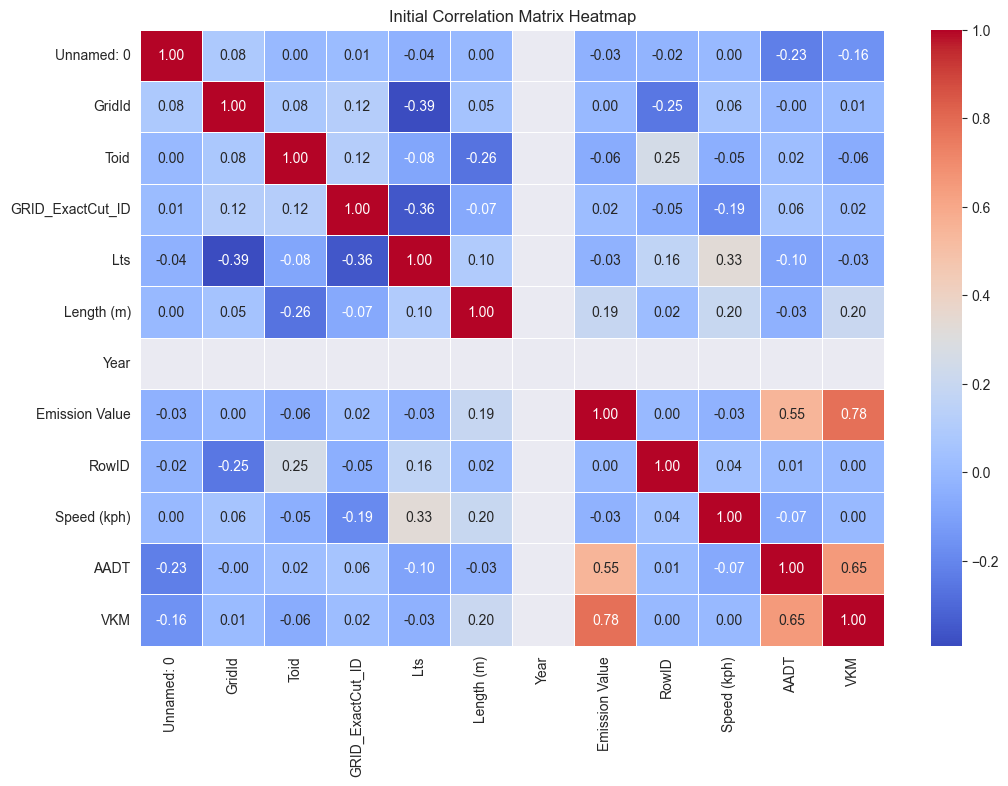

In [5]:
# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Initial heatmap of the correlation matrix
initial_correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

# # Initial heatmap of the correlation matrix
# initial_correlation_matrix = df.corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Initial Correlation Matrix Heatmap')
# plt.show()

In [6]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Emissions Unit', 'VehicleType', 'Pollutant']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['Emission Value'].abs().sort_values(ascending=False)
print(target_corr)

Emission Value          1.000000
VKM                     0.778763
AADT                    0.546873
Length (m)              0.193900
VehicleType             0.075468
Toid                    0.055868
Unnamed: 0              0.033266
Speed (kph)             0.032406
Lts                     0.031983
GRID_ExactCut_ID        0.018073
BoroughName_ExactCut    0.017632
Location_ExactCut       0.004152
RowID                   0.002650
GridId                  0.002186
Emissions                    NaN
Year                         NaN
Pollutant                    NaN
Emissions Unit               NaN
Name: Emission Value, dtype: float64


['Emission Value', 'VKM', 'AADT', 'Length (m)', 'VehicleType', 'Toid']


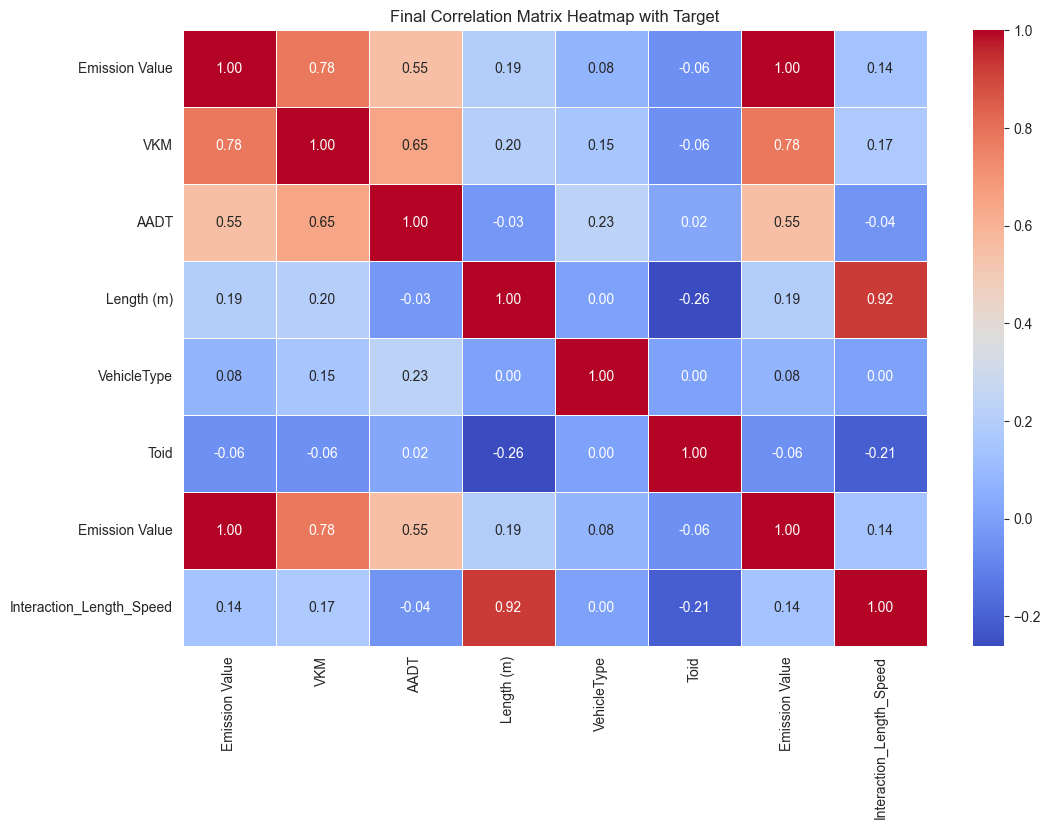

In [7]:
# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()
print(selected_features)
# # Add the target variable back to the selected features
selected_features.append('Emission Value')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
# df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# # Redefine features and preprocess again
# selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']
selected_features = selected_features + ['Interaction_Length_Speed']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

In [8]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['Emission Value'])
y = df['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

        VKM      AADT  Length (m)  VehicleType      Toid  \
0 -0.023502  0.095732   -0.327321     0.434524 -6.243198   
1 -0.246166 -0.353113   -0.578696     0.434524 -6.144199   
2  1.043801  0.095732    2.431609     0.434524 -6.298176   
3 -0.246166 -0.353113   -0.583481     0.434524 -6.298100   
4  0.915810  0.242550    1.360420     0.434524 -6.298087   

   Interaction_Length_Speed  
0                 -0.117514  
1                 -0.444328  
2                  2.061928  
3                 -0.455785  
4                  0.587842  


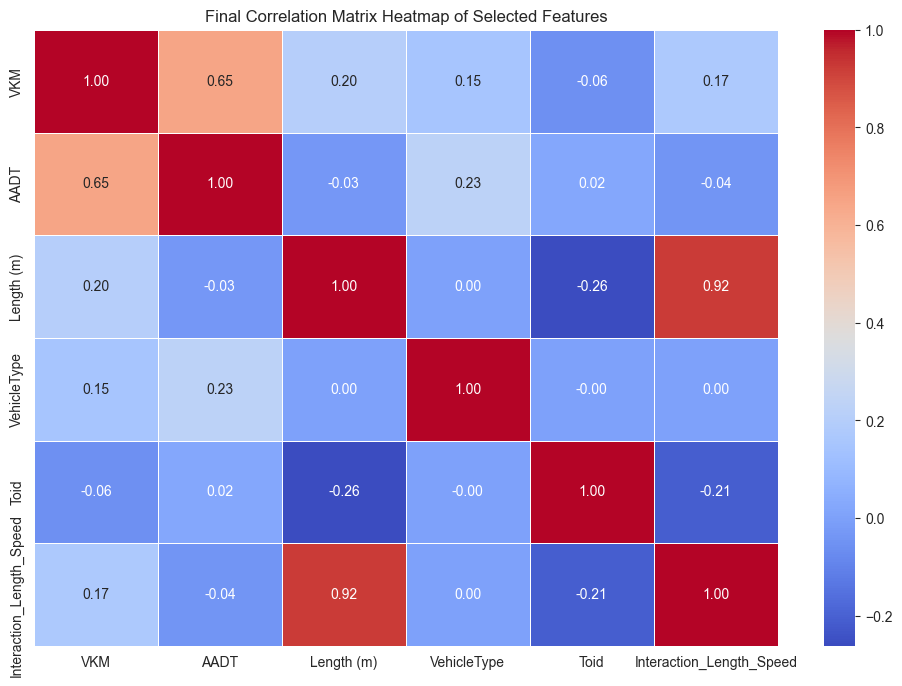

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [10]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)

{'X_train_shape': (269529, 6), 'X_test_shape': (67383, 6), 'y_train_shape': (269529,), 'y_test_shape': (67383,), 'features': ['Emission Value', 'VKM', 'AADT', 'Length (m)', 'VehicleType', 'Toid', 'Emission Value'], 'target': 'Emission Value'}


In [11]:
# Train and evaluate Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

In [12]:
# Define and test a few hyperparameter combinations
rf1 = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

rf2 = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

In [15]:
# Define the neural network model
nn_model = Sequential()
nn_model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
# nn_model.add(Dropout(0.2))
# nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_nn = nn_model.predict(X_test).flatten()

Epoch 1/150
6739/6739 [==============================] - 5s 694us/step - loss: 5.8563 - val_loss: 5.0837
Epoch 2/150
6739/6739 [==============================] - 5s 751us/step - loss: 4.5171 - val_loss: 3.8691
Epoch 3/150
6739/6739 [==============================] - 5s 702us/step - loss: 3.5645 - val_loss: 3.2622
Epoch 4/150
6739/6739 [==============================] - 5s 799us/step - loss: 3.1466 - val_loss: 2.8375
Epoch 5/150
6739/6739 [==============================] - 5s 749us/step - loss: 2.6873 - val_loss: 2.5142
Epoch 6/150
6739/6739 [==============================] - 5s 704us/step - loss: 2.4060 - val_loss: 2.4661
Epoch 7/150
6739/6739 [==============================] - 5s 711us/step - loss: 2.1941 - val_loss: 2.0614
Epoch 8/150
6739/6739 [==============================] - 5s 804us/step - loss: 1.9420 - val_loss: 1.8705
Epoch 9/150
6739/6739 [==============================] - 6s 867us/step - loss: 1.8121 - val_loss: 1.7176
Epoch 10/150
6739/6739 [==============================]

KeyboardInterrupt: 

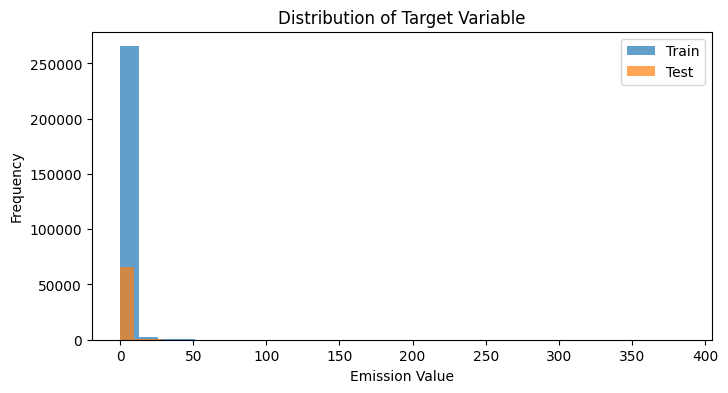

In [21]:
# Plot the distribution of target values
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.title('Distribution of Target Variable')
plt.xlabel('Emission Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Evaluate Models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

linear_metrics = evaluate_model(y_test, y_pred_lr)
rf1_metrics = evaluate_model(y_test, y_pred_rf1)
rf2_metrics = evaluate_model(y_test, y_pred_rf2)

# nn_metrics = evaluate_model(y_test, y_pred_nn)

print("Linear Regression Metrics (MAE, MSE, R^2):", linear_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf1_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf2_metrics)
# print("Neural Network Metrics (MAE, MSE, R^2):", nn_metrics)

Linear Regression Metrics (MAE, MSE, R^2): (0.7890358769459219, 6.8067567126910875, 0.6227407952399047)
Random Forest Metrics (MAE, MSE, R^2): (0.3300277685706647, 1.4574949331423042, 0.9192194752026408)
Random Forest Metrics (MAE, MSE, R^2): (0.15691081411366598, 0.6616528144605045, 0.9633284065896984)
